In [3]:
!sudo apt install -y fluidsynth

'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

     |████████████████████████████████| 5.6 MB 4.3 MB/s 
     |████████████████████████████████| 51 kB 6.0 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=15ea76c956f005e74063dc8ab50ff5fd0afa2b65372eaadc1394ef1cf0e3d567
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

ModuleNotFoundError: No module named 'fluidsynth'

In [1]:
seed = 56
tf.random.set_seed(seed)
np.random.seed(seed)

#Sampling rate
_SAMPLING_RATE = 16000

NameError: name 'tf' is not defined

In [ ]:
data_dir = pathlib.Path('data/lmd_matched')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'lmd.zip',
      origin='http://hog.ee.columbia.edu/craffel/lmd/lmd_matched.tar.gz',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

1407082496/1407072670 [==============================] - 122s 0us/step


The dataset contains about 1,200 MIDI files.

In [ ]:
filenames = glob.glob(str(data_dir/'*/*/*/*/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 116189


In [ ]:
sample_file = filenames[1]
print(sample_file)

data/lmd_matched/T/T/T/TRTTTRV128F428E82F/a8daaf582728a26ffa2f6e85239f84c3.mid


In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 6
Instrument name: Acoustic Grand Piano


In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=42, note_name=F#2, duration=0.0208
1: pitch=42, note_name=F#2, duration=0.0208
2: pitch=42, note_name=F#2, duration=0.0208
3: pitch=54, note_name=F#3, duration=0.1250
4: pitch=42, note_name=F#2, duration=0.0208
5: pitch=42, note_name=F#2, duration=0.0208
6: pitch=42, note_name=F#2, duration=0.0208
7: pitch=42, note_name=F#2, duration=0.0208
8: pitch=54, note_name=F#3, duration=0.1250
9: pitch=42, note_name=F#2, duration=0.0208


In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,42,2.00,2.020833,0.00,0.020833
1,42,2.25,2.270833,0.25,0.020833
2,42,2.50,2.520833,0.25,0.020833
3,54,2.50,2.625000,0.00,0.125000
4,42,2.75,2.770833,0.25,0.020833


In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['F#2', 'F#2', 'F#2', 'F#3', 'F#2', 'F#2', 'F#2', 'F#2', 'F#3',
       'F#2'], dtype='<U3')

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

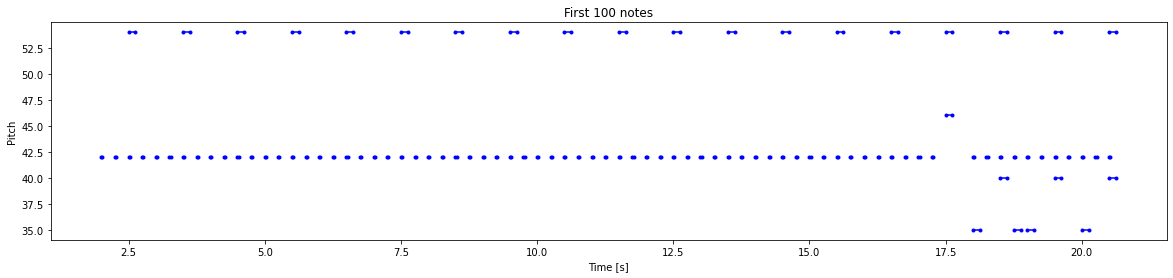

In [ ]:
plot_piano_roll(raw_notes, count=100)

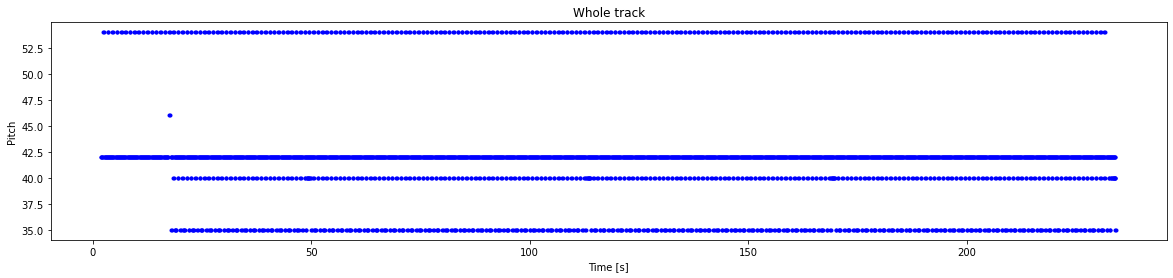

In [ ]:
plot_piano_roll(raw_notes)

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

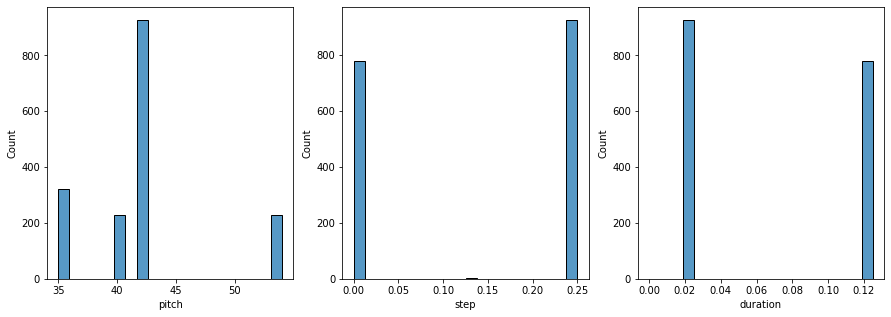

In [ ]:
plot_distributions(raw_notes)

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [ ]:
display_audio(example_pm)

In [ ]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 5461


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.515625   0.         0.17137098]
 [0.5390625  0.         0.19153227]
 [0.484375   0.         0.22681453]
 [0.484375   0.25705647 0.1764113 ]
 [0.515625   0.         0.1764113 ]
 [0.5390625  0.         0.18649195]
 [0.5        0.23185485 0.21169356]
 [0.5234375  0.         0.22681453]
 [0.46875    0.00504032 0.19153227]
 [0.46875    0.24697582 0.28729841]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=60.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.20161291666666692>}


In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

84/84 [==============================] - 6s 10ms/step - loss: 6.1729 - duration_loss: 0.2888 - pitch_loss: 4.8514 - step_loss: 1.0327


{'duration_loss': 0.28879424929618835,
 'loss': 6.172931671142578,
 'pitch_loss': 4.851421356201172,
 'step_loss': 1.032716989517212}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

84/84 [==============================] - 2s 6ms/step - loss: 1.5641 - duration_loss: 0.2888 - pitch_loss: 4.8514 - step_loss: 1.0327


{'duration_loss': 0.28879424929618835,
 'loss': 1.564082384109497,
 'pitch_loss': 4.851421356201172,
 'step_loss': 1.032716989517212}

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
84/84 [==============================] - 4s 13ms/step - loss: 1.3387 - duration_loss: 0.1654 - pitch_loss: 4.1225 - step_loss: 0.9672
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 1.2354 - duration_loss: 0.1442 - pitch_loss: 3.1600 - step_loss: 0.9331
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 1.1460 - duration_loss: 0.1263 - pitch_loss: 2.6130 - step_loss: 0.8891
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 1.0973 - duration_loss: 0.1154 - pitch_loss: 2.3029 - step_loss: 0.8667
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 1.1128 - duration_loss: 0.1174 - pitch_loss: 2.2741 - step_loss: 0.8816
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 1.0606 - duration_loss: 0.1059 - pitch_loss: 2.1786 - step_loss: 0.8458
Epoch 7/50
84/84 [==============================] - 1s 12ms/step - loss: 1.0374 - duration_loss: 0.1000 - pitch_loss: 2.0418 - ste

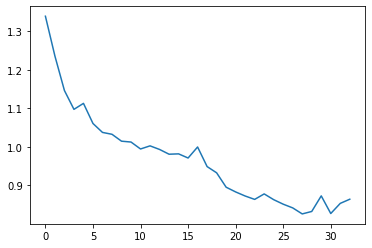

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,42,0.459912,0.102829,0.459912,0.562740
1,54,0.000000,0.000000,0.459912,0.459912
2,54,0.000000,0.000000,0.459912,0.459912
3,54,0.000000,0.000000,0.459912,0.459912
4,54,0.000000,0.000000,0.459912,0.459912
5,54,0.000000,0.000000,0.459912,0.459912
6,54,0.000000,0.000000,0.459912,0.459912
7,54,0.000000,0.000000,0.459912,0.459912
8,54,0.000000,0.000000,0.459912,0.459912
9,54,0.000000,0.000000,0.459912,0.459912


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

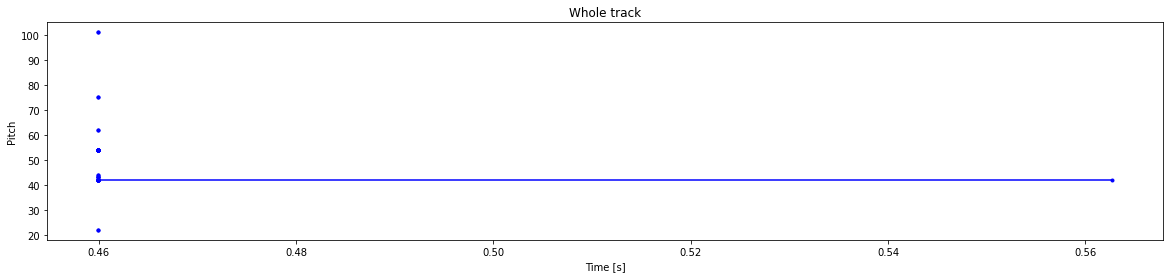

In [ ]:
plot_piano_roll(generated_notes)

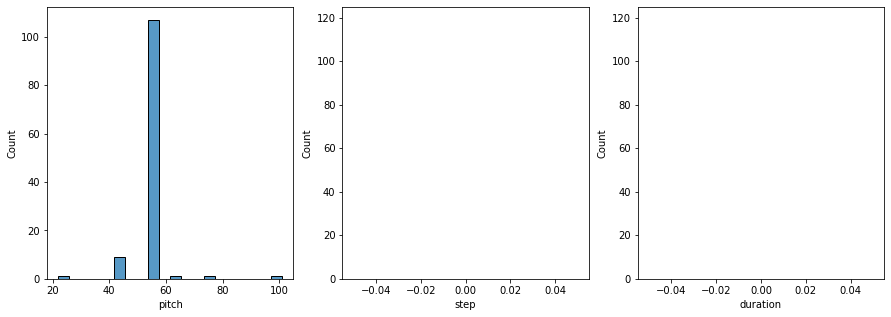

In [ ]:
plot_distributions(generated_notes)